## LSTM models
We developed 4 models with two extra modifications.

## Model Summaries
The project began with Model 1, a minimal LSTM baseline designed to confirm that sequential stock data could be framed as a binary classification problem. 

As mOdel 1 shows a near-random accuracy, we introduced Model 2-A with deeper dense layers and dropout to capture richer nonlinear dependencies among features, while Model 2-B extended training to test convergence and overfitting behavior. 

To move beyond binary labels, in Model 3-A we redefined the target as a continuous “relative-price-up” score to capture the importance of increased values as well, also extending the temporal window to 100 days to capture medium-term momentum; Model 3-B further refined this regression-style approach with tuned hyperparameters. 

In Model 4-A incorporated symbol embeddings to learn across multiple tickers simultaneously, as the stock behaviors might share latent patterns, and Model 4-B deepened this architecture to enhance representational capacity. 

Across iterations, the modeling strategy evolved from simple sequence learning to multi-stock representation learning, revealing that while architecture and temporal depth offered modest recall gains, true predictive improvement likely requires feature enrichment (technical indicators, sentiment, or macroeconomic data) and longer-horizon context rather than additional model complexity.

Here is the summary of the models architecture, key aspect and their performance

| **Model**                                     | **Architecture / Setup**                                                                                                            | **Key Idea**                                                                        | **Performance Summary**                                                                |
| --------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------- |
| **Model 1 – Baseline LSTM**                   | 1 LSTM layer (64 units) + Dropout (0.2) + Dense(1, sigmoid); 20-day window                                                          | Establishes baseline binary classifier for next-day price movement.                 | Accuracy ≈ 0.51 — learns basic sequence structure but no predictive edge.          |
| **Model 2-A – Deeper LSTM**                   | 1 LSTM(64) → Dense(64, softplus) → Dropout(0.1) → Dense(12, softplus) → Dense(1, sigmoid); 20-day window                            | Adds nonlinear dense layers and optimized Adam(β₁=0.95) for better representation.  | Slight gain in F1 (~0.54), still near random accuracy (~0.51).                         |
| **Model 2-B – Extended Training**             | Same as 2-A, trained up to 100 epochs with early stopping                                                                           | Tests effect of longer convergence and stability.                                   | Accuracy ~0.51; performance saturates early; minimal overfitting.                      |
| **Model 3-A – Regression-Style LSTM**         | 1 LSTM(64) → Dense(64, softplus) → Dropout(0.1) → Dense(12, softplus) → Dense(1, sigmoid); 100-day window; loss = MSE               | Switches to continuous target (relative_price_up) to capture magnitude of change. | Recall improves (~0.58), showing better sensitivity to upward moves.                   |
| **Model 3-B – Regression LSTM (tuned)**       | Same as 3-A, with minor tuning (learning rate, patience, epochs)                                                                    | Evaluates model robustness on continuous targets.                                   | Similar to 3-A; stable but not superior to binary classification.                      |
| **Model 4-A – Multi-Stock LSTM w/ Embedding** | Symbol Embedding(8) + RepeatVector + Concatenate + LSTM(64) + Dropout(0.2) + Dense(32, softplus) + Dense(1, sigmoid); 60-day window | Introduces stock ID embeddings to learn cross-stock patterns jointly.               | Recall drops (~0.40); model complexity increases but generalization weakens.           |
| **Model 4-B – Tuned Multi-Stock LSTM**        | Embedding(12) + LSTM(64) + Dense(64→32, softplus) + Dropout(0.2×2) + Dense(1, sigmoid); lr=3e-3; 60 epochs                          | Expands embedding and dense depth for richer representation.                        | Accuracy ≈ 0.50, ROC-AUC ≈ 0.51 — added complexity offers no significant gain. |


## Performance summary:
All models performed close to random (accuracy ≈ 0.50–0.52, ROC-AUC ≈ 0.5), indicating that historical price features alone are insufficient for daily trend prediction.

Deeper or longer models (2-B, 3-A/B) marginally improved recall, capturing more “up” movements but not overall accuracy.

Embedding models (4-A/B) introduced richer representations but failed to generalize, likely due to inter-stock variability and limited feature diversity.

Future improvements should emphasize:

Feature enrichment: add technical indicators, sentiment, or macro data.

Longer context: use 60–120 day windows to capture trend persistence.

Hybrid modeling: combine LSTM outputs with ensemble or transformer layers.

In [47]:
import os
print(os.getcwd())


c:\Users\cheki\dsi\project


## Loading the optimized data file after the EDA

In [48]:
import pandas as pd

# Loading the optimized data file after the EDA
df_scaled = pd.read_parquet( r"Stock-Trend-Analysis-with-NYSE\Data\outputs\df_scaled.parquet")

print(df_scaled.shape)
print(df_scaled.head())
print(df_scaled.dtypes)


(850763, 9)
         date symbol  price_up_tomorrow  open_scaled  high_scaled  low_scaled  \
0  2010-01-05      A                  0    -1.580240    -1.624734   -1.576714   
1  2010-01-06      A                  0    -1.614880    -1.645883   -1.576714   
2  2010-01-07      A                  0    -1.621616    -1.663186   -1.601739   
3  2010-01-08      A                  1    -1.635088    -1.660303   -1.611364   
4  2010-01-11      A                  0    -1.611994    -1.641076   -1.585377   

   close_scaled  volume_scaled  log_return_1d_scaled  
0     -1.606207       0.108336             -0.602399  
1     -1.616791      -0.286812             -0.210777  
2     -1.620640      -0.349126             -0.090472  
3     -1.621602      -0.081249             -0.038724  
4     -1.619677       0.358056              0.013071  
date                     object
symbol                   object
price_up_tomorrow         int32
open_scaled             float64
high_scaled             float64
low_scaled 

## Bulding sequences for each symbol
The goal is to build time-series sequences per stock (as beeing used later on for LSTM input)
We define a windoe (here 20-days) as look-back window, fixing the random seed, using the six scaled price/volume features, and setting the binary target price_up_tomorrow. 

The helper funciton "make_sequences_symbol()" sorts each symbol’s data by date and creates sliding windows of shape (window=20, features=6). For each window it pairs the next day’s target label, returning:
    X: NumPy array of sequences with shape (n_samples, 20, 6)
    y: NumPy array of binary labels (n_samples, )

These sequences are later concatenated across symbols and used to train LSTM models while preserving time order (with no leakage).

In [49]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
np.random.seed(42)

# Defining features, target,and the window for splitting the data by time (20 days here) 
features = ['open_scaled','high_scaled','low_scaled','close_scaled','volume_scaled', 'log_return_1d_scaled'] # gave error for log_return so removed it
target   = 'price_up_tomorrow'
window   = 20  # last 20 days per sample (as N)

# defining a helper function
def make_sequences_symbol(sequence, features, target, window):
    sequence = sequence.sort_values('date') # sorting based onthe date
    X =[] #inputs with the size of 20 (N)x 6 (number of features)
    y = [] # out puts of 0 or 1
    vals = sequence[features].values # all of our inputs, converting to NumPy array as LSTM need numeric arrays, not pandas tables.
    tgt  = sequence[target].values   # our predictions, converting the single column into a NumPy array
    # the loop;to make the first 20-day window, we need 20 previous days, so starting from window (here 20) to the last data point
    for i in range(window, len(sequence)):
        X.append(vals[i-window:i])
        y.append(tgt[i])
    return np.array(X), np.array(y)


## Train-Test split

In [50]:
# Splitting the data into training and testing sets while keeping the data's time order
# Initialize empty containers for both test and train sets
X_tr, y_tr, X_te, y_te = [], [], [], []

    # looping over each stock, generate its sequences, and drop them in these lists
for sym, g in df_scaled.groupby('symbol'):
    n = len(g) # gives total number of rows (days) for that symbol
    cut = int(n*0.8)  # we do not randomize here like in the course, it should be time-aware split
    g_tr = g.iloc[:cut] # geeting the first 80% of days for training
    g_te = g.iloc[cut:] # the 20% rest of data for testing 

    X1, y1 = make_sequences_symbol(g_tr, features, target, window)
    X2, y2 = make_sequences_symbol(g_te, features, target, window)

    # skipping the ones with less than defined winodow length
    if len(X1): X_tr.append(X1); y_tr.append(y1)
    if len(X2): X_te.append(X2); y_te.append(y2)
# merging all the small NumPy arrays from the list into one big array
X_train = np.concatenate(X_tr, axis=0)
y_train = np.concatenate(y_tr, axis=0)
X_test  = np.concatenate(X_te, axis=0)
y_test  = np.concatenate(y_te, axis=0)
# checking the shape and dimensions
print(X_train.shape, X_test.shape)  # (samples, window, features)


(670201, 20, 6) (160522, 20, 6)


## Model 1
### Description: 
A simple one-layer LSTM with 64 units, 20-day window, and dropout (0.2) trained on six scaled price features to predict price_up_tomorrow.

First baseline model; establishes core sequence-to-label pipeline using minimal architecture and binary cross-entropy loss.

In [23]:
model1 = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), # to prevent overfitting, randomly 20% of neurons are 0 during the training
    Dense(1, activation='sigmoid') # since we are doing binary classification, the sigmoid activation function is suitable, if f output > 0.5 we predict up
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                18176     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Train the model
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
history2 = model1.fit(X_train, y_train,
                      epochs=20, batch_size=256,
                      validation_split=0.1, shuffle=False,
                      callbacks=[es])

Epoch 1/20
2357/2357 [==============================] - 62s 26ms/step - loss: 0.6919 - accuracy: 0.5177 - val_loss: 0.6904 - val_accuracy: 0.5234
Epoch 2/20
2357/2357 [==============================] - 65s 27ms/step - loss: 0.6892 - accuracy: 0.5248 - val_loss: 0.6868 - val_accuracy: 0.5302
Epoch 3/20
2357/2357 [==============================] - 61s 26ms/step - loss: 0.6851 - accuracy: 0.5321 - val_loss: 0.6838 - val_accuracy: 0.5330
Epoch 4/20
2357/2357 [==============================] - 60s 25ms/step - loss: 0.6815 - accuracy: 0.5370 - val_loss: 0.6794 - val_accuracy: 0.5399
Epoch 5/20
2357/2357 [==============================] - 59s 25ms/step - loss: 0.6784 - accuracy: 0.5414 - val_loss: 0.6774 - val_accuracy: 0.5432
Epoch 6/20
2357/2357 [==============================] - 62s 26ms/step - loss: 0.6757 - accuracy: 0.5457 - val_loss: 0.6764 - val_accuracy: 0.5438
Epoch 7/20
2357/2357 [==============================] - 63s 27ms/step - loss: 0.6735 - accuracy: 0.5480 - val_loss: 0.6738 -

Model1 evaluation

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_prob = model1.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int) #Converts those probabilities into binary class predictions

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion_matrix:", confusion_matrix(y_test, y_pred))
print("Classification_report:\n", classification_report(y_test, y_pred, digits=3))


5017/5017 [==============================] - 20s 4ms/step
Accuracy: 0.5086530195238036
Confusion_matrix: [[34048 43393]
 [35479 47602]]
Classification_report:
               precision    recall  f1-score   support

           0      0.490     0.440     0.463     77441
           1      0.523     0.573     0.547     83081

    accuracy                          0.509    160522
   macro avg      0.506     0.506     0.505    160522
weighted avg      0.507     0.509     0.507    160522



## Interpretation:

Feature redundancy:
We are using correlated inputs (open, high, low, close), which contain overlapping price information. This limits new signal extraction and can lead to overfitting on short-term fluctuations that don’t generalize well.

Inherent prediction difficulty:
Daily stock direction is dominated by external, non-price factors (macroeconomic news, market sentiment, unexpected events). With only historical prices and volume, the signal-to-noise ratio is very low — hence the near-random (~0.50) accuracy.

Temporal limitation:
The 20-day look-back window may be too short to capture meaningful market momentum or medium-term trends. Extending the sequence length (e.g., 50–100 days) or adding derived trend features could improve temporal learning. We are tesing this in Model3 chaning window from 20 to 100 days.


In [26]:
# checking the class balance
y_train.mean(), y_test.mean()

(0.5170060922021901, 0.5175676854262967)

dataset is well balanced, so something else is the reason for bad performance


## Model 2-A (Deeper LSTM with dense layers)
Description: 
Added two fully connected Dense layers (64 → 12 → 1) using softplus activations and lighter dropout (0.1) for richer nonlinear mapping.

New vs Model 1: 
Introduces hidden dense layers and tuned optimizer (Adam with β₁ = 0.95) to improve representational power and generalization.

In [51]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# define the model architecture
model2 = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(64, activation='softplus' ),
    Dropout(0.1),  # to prevent overfitting, randomly 10% of neurons are 0 during training
    Dense(12, activation='softplus'),
    
    Dense(1, activation='sigmoid')  # binary classification (up or down)
])

# define optimizer with momentum-like parameters
opt = Adam(learning_rate=1e-2, beta_1=0.95, beta_2=0.999)

# compile the model (outside Sequential)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                18176     
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 12)                780       
                                                                 
 dense_17 (Dense)            (None, 1)                 13        
                                                                 
Total params: 23,129
Trainable params: 23,129
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Train the model
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
history2 = model2.fit(X_train, y_train,
                      epochs=20, batch_size=256,
                      validation_split=0.1, shuffle=False,
                      callbacks=[es])

Epoch 1/20
2357/2357 [==============================] - 59s 24ms/step - loss: 0.6929 - accuracy: 0.5155 - val_loss: 0.6908 - val_accuracy: 0.5254
Epoch 2/20
2357/2357 [==============================] - 57s 24ms/step - loss: 0.6895 - accuracy: 0.5247 - val_loss: 0.6876 - val_accuracy: 0.5287
Epoch 3/20
2357/2357 [==============================] - 56s 24ms/step - loss: 0.6851 - accuracy: 0.5312 - val_loss: 0.6826 - val_accuracy: 0.5357
Epoch 4/20
2357/2357 [==============================] - 59s 25ms/step - loss: 0.6815 - accuracy: 0.5367 - val_loss: 0.6792 - val_accuracy: 0.5400
Epoch 5/20
2357/2357 [==============================] - 57s 24ms/step - loss: 0.6782 - accuracy: 0.5419 - val_loss: 0.6768 - val_accuracy: 0.5432
Epoch 6/20
2357/2357 [==============================] - 57s 24ms/step - loss: 0.6753 - accuracy: 0.5460 - val_loss: 0.6747 - val_accuracy: 0.5469
Epoch 7/20
2357/2357 [==============================] - 56s 24ms/step - loss: 0.6724 - accuracy: 0.5494 - val_loss: 0.6729 -

In [53]:
y_prob = model2.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int) #Converts those probabilities into binary class predictions

print("Accuracy:", accuracy_score(y_test, y_pred))
print("confusion_matrix:", confusion_matrix(y_test, y_pred))
print("classification_report:")
print(classification_report(y_test, y_pred, digits=3))

5017/5017 [==============================] - 16s 3ms/step
Accuracy: 0.5069647774136878
confusion_matrix: [[38650 38791]
 [40352 42729]]
classification_report:
              precision    recall  f1-score   support

           0      0.489     0.499     0.494     77441
           1      0.524     0.514     0.519     83081

    accuracy                          0.507    160522
   macro avg      0.507     0.507     0.507    160522
weighted avg      0.507     0.507     0.507    160522



## Model 2-B (higher # of epochs)
Description: Same architecture as Model 2 but trained for 200 epochs with early stopping.
New vs Model 2: Tests longer training to assess convergence behavior and stability over more epochs.

In [54]:
# Train the model2
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
history2 = model2.fit(X_train, y_train,
                      epochs=100, batch_size=256,
                      validation_split=0.1, shuffle=False,
                      callbacks=[es])

Epoch 1/100
2357/2357 [==============================] - 75s 32ms/step - loss: 0.6523 - accuracy: 0.5772 - val_loss: 0.6666 - val_accuracy: 0.5638
Epoch 2/100
2357/2357 [==============================] - 70s 30ms/step - loss: 0.6514 - accuracy: 0.5791 - val_loss: 0.6671 - val_accuracy: 0.5649
Epoch 3/100
2357/2357 [==============================] - 70s 30ms/step - loss: 0.6506 - accuracy: 0.5793 - val_loss: 0.6675 - val_accuracy: 0.5636
Epoch 4/100
2357/2357 [==============================] - 69s 29ms/step - loss: 0.6500 - accuracy: 0.5805 - val_loss: 0.6673 - val_accuracy: 0.5638
Epoch 5/100
2357/2357 [==============================] - 71s 30ms/step - loss: 0.6491 - accuracy: 0.5811 - val_loss: 0.6677 - val_accuracy: 0.5648
Epoch 6/100
2357/2357 [==============================] - 71s 30ms/step - loss: 0.6485 - accuracy: 0.5817 - val_loss: 0.6675 - val_accuracy: 0.5650


In [55]:
y_prob = model2.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int) #Converts those probabilities into binary class predictions

print("Accuracy:", accuracy_score(y_test, y_pred))
print("confusion_matrix:", confusion_matrix(y_test, y_pred))
print("classification_report:")
print(classification_report(y_test, y_pred, digits=3))

5017/5017 [==============================] - 18s 4ms/step
Accuracy: 0.5055257223308954
confusion_matrix: [[39453 37988]
 [41386 41695]]
classification_report:
              precision    recall  f1-score   support

           0      0.488     0.509     0.499     77441
           1      0.523     0.502     0.512     83081

    accuracy                          0.506    160522
   macro avg      0.506     0.506     0.505    160522
weighted avg      0.506     0.506     0.506    160522



## Data engineering
Adding a new feature, 

## Adding a new feature: Relative_price_up

First, we create a smooth “relative upward movement” score between 0 and 1, relative to the amount each stock went up and down, instead of a binary 0/1 label.

Then, we use it for regression-like target (target = 'relative_price_up') in Model 3, which tries to predict how strongly the next day’s price will move rather than just “up or down.”

In [56]:
from scipy.special import expit as sigmoid

df_scaled['relative_price_up'] = sigmoid(
    (df_scaled['close_scaled'].shift(-1) - df_scaled['close_scaled']) / ((df_scaled['close_scaled'].shift(-1) - df_scaled['close_scaled']).std()*0.5)
    #/np.abs(df_scaled['close_scaled'].shift(-1) - df_scaled['close_scaled']).max()
    #np.maximum(
       # df_scaled['close_scaled'].abs(),
        #(df_scaled['close_scaled'].shift(-1) - df_scaled['close_scaled']).abs()
    #)
)
#print(np.abs(df_scaled['close_scaled'].shift(-1) - df_scaled['close_scaled']).max())
#print(np.abs(df_scaled['close_scaled'].shift(-1) - df_scaled['close_scaled']).min())

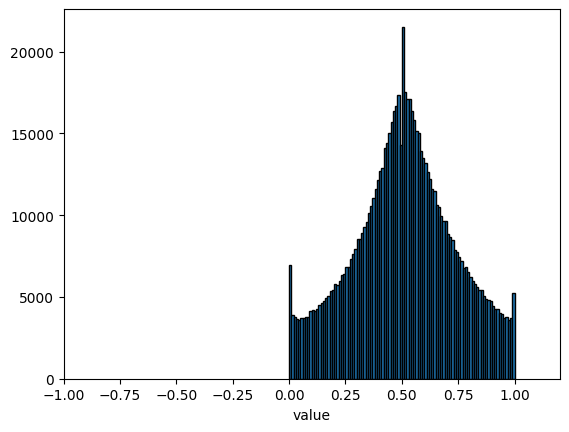

In [57]:
import matplotlib.pyplot as plt
plt.hist(df_scaled['relative_price_up'], bins=100, edgecolor='black')
plt.xlabel ('value')
plt.xlim(-1, 1.2)
plt.show()

In [58]:
df_scaled

,date,symbol,price_up_tomorrow,open_scaled,high_scaled,low_scaled,close_scaled,volume_scaled,log_return_1d_scaled,relative_price_up
0,2010-01-05,A,0,-1.580240,-1.624734,-1.576714,-1.606207,0.108336,-0.602399,0.443670
1,2010-01-06,A,0,-1.614880,-1.645883,-1.576714,-1.616791,-0.286812,-0.210777,0.479440
2,2010-01-07,A,0,-1.621616,-1.663186,-1.601739,-1.620640,-0.349126,-0.090472,0.494858
3,2010-01-08,A,1,-1.635088,-1.660303,-1.611364,-1.621602,-0.081249,-0.038724,0.510285
4,2010-01-11,A,0,-1.611994,-1.641076,-1.585377,-1.619677,0.358056,0.013071,0.318402
...,...,...,...,...,...,...,...,...,...,...
850758,2016-12-23,ZTS,0,1.684114,1.696478,1.754204,1.759812,-0.620910,0.603668,0.458685
850759,2016-12-27,ZTS,0,1.759014,1.743886,1.815477,1.752065,-0.805081,-0.110024,0.315829
850760,2016-12-28,ZTS,1,1.756431,1.705447,1.776367,1.715908,-0.836866,-0.380788,0.621737
850761,2016-12-29,ZTS,0,1.718981,1.696478,1.782886,1.739151,-0.897044,0.185067,0.438201


developing a new model
## model 3 (Regression-style LSTM with new target)

Description: Predicts a continuous relative-price-change target (relative_price_up) computed via a sigmoid transform of next-day price difference; uses 100-day windows and MSE loss.

New vs Model 2: Switches target from binary class to continuous value, extends temporal context (100 days), and uses mean-squared-error for regression-like learning.

In [ ]:
# Defining features, target,and the window for splitting the data by time (20 days here) 
features = ['open_scaled','high_scaled','low_scaled','close_scaled','volume_scaled','log_return_1d_scaled']
target   = 'relative_price_up'
window2   = 100  # last 100 days per sample (as N)

# defining a helper function
def make_sequences_symbol(sequence, features, target, window2):
    sequence = sequence.sort_values('date') # sorting based onthe date
    X =[] #inputs with the size of 20 (N)x 6 (number of features)
    y = [] # out puts of 0 or 1
    vals = sequence[features].values # all of our inputs, converting to NumPy array as LSTM need numeric arrays, not pandas tables.
    tgt  = sequence[target].values   # our predictions, converting the single column into a NumPy array
    # the loop;to make the first 100-day window, we need 20 previous days, so starting from window (here 100) to the last data point
    for i in range(window2, len(sequence)):
        X.append(vals[i-window2:i])
        y.append(tgt[i])
    return np.array(X), np.array(y)
# Splitting the data into training and testing sets while keeping the data's time order
# Initialize empty containers for both test and train sets
X_tr, y_tr, X_te, y_te = [], [], [], []

    # looping over each stock, generate its sequences, and drop them in these lists
for sym, g in df_scaled.groupby('symbol'):
    n = len(g) # gives total number of rows (days) for that symbol
    cut = int(n*0.8)  # we do not randomize here like in the course, it should be time-aware split
    g_tr = g.iloc[:cut] # geeting the first 80% of days for training
    g_te = g.iloc[cut:] # the 20% rest of data for testing 

    X1, y1 = make_sequences_symbol(g_tr, features, target, window2)
    X2, y2 = make_sequences_symbol(g_te, features, target, window2)

    # skipping the ones with less than defined winodow length
    if len(X1): X_tr.append(X1); y_tr.append(y1)
    if len(X2): X_te.append(X2); y_te.append(y2)
# merging all the small NumPy arrays from the list into one big array
X_train = np.concatenate(X_tr, axis=0)
y_train = np.concatenate(y_tr, axis=0)
X_test  = np.concatenate(X_te, axis=0)
y_test  = np.concatenate(y_te, axis=0)
# checking the shape and dimensions
print(X_train.shape, X_test.shape)  # (samples, window, features)

(630121, 100, 6) (120720, 100, 6)


In [60]:
model3 = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(64, activation='softplus' ),
    Dropout(0.1),  # to prevent overfitting, randomly 10% of neurons are 0 during training
    Dense(12, activation='softplus'),
    
    Dense(1, activation='sigmoid')  # binary classification (up or down)
])
model3.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 64)                18176     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 12)                780       
                                                                 
 dense_20 (Dense)            (None, 1)                 13        
                                                                 
Total params: 23,129
Trainable params: 23,129
Non-trainable params: 0
_________________________________________________________________


In [61]:
target
df_scaled['relative_price_up'].std()

0.22628762423808227

In [62]:
# Train the model3
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
history3 = model3.fit(X_train, y_train,
                      epochs=20, batch_size=256,
                      validation_split=0.1, shuffle=False,
                      callbacks=[es])

Epoch 1/20
2216/2216 [==============================] - 334s 149ms/step - loss: 0.0474 - accuracy: 2.4687e-05 - val_loss: 0.0483 - val_accuracy: 7.9349e-05
Epoch 2/20
2216/2216 [==============================] - 323s 146ms/step - loss: 0.0468 - accuracy: 2.2923e-05 - val_loss: 0.0477 - val_accuracy: 7.9349e-05
Epoch 3/20
2216/2216 [==============================] - 322s 145ms/step - loss: 0.0463 - accuracy: 2.2923e-05 - val_loss: 0.0472 - val_accuracy: 7.9349e-05
Epoch 4/20
2216/2216 [==============================] - 322s 145ms/step - loss: 0.0460 - accuracy: 2.2923e-05 - val_loss: 0.0469 - val_accuracy: 7.9349e-05
Epoch 5/20
2216/2216 [==============================] - 323s 146ms/step - loss: 0.0457 - accuracy: 2.2923e-05 - val_loss: 0.0464 - val_accuracy: 7.9349e-05
Epoch 6/20
2216/2216 [==============================] - 331s 149ms/step - loss: 0.0453 - accuracy: 2.2923e-05 - val_loss: 0.0459 - val_accuracy: 7.9349e-05
Epoch 7/20
2216/2216 [==============================] - 332s 150

In [76]:
y_prob = model3.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int) #Converts those probabilities into binary class predictions

print("Accuracy model3:", accuracy_score(y_test, y_pred))
print("onfusion_matrix:", confusion_matrix(y_test, y_pred))
print("lassification_report:")
print(classification_report(y_test, y_pred, digits=3))

4392/4392 [==============================] - 53s 12ms/step
Accuracy model3: 0.5016651248843663
onfusion_matrix: [[28664 39632]
 [30399 41835]]
lassification_report:
              precision    recall  f1-score   support

           0      0.485     0.420     0.450     68296
           1      0.514     0.579     0.544     72234

    accuracy                          0.502    140530
   macro avg      0.499     0.499     0.497    140530
weighted avg      0.500     0.502     0.499    140530



Need to change the loss-function and remove the NAN data!

## model 4-A (Multi-stock LSTM with symbol embeddings)

Description: Adds a symbol embedding layer to learn stock-specific representations jointly across all tickers (window = 60 days).

New vs Model 3: Moves from single-stock to multi-stock modeling, introducing embedding, concatenation of symbol vector with feature sequence, and dual-input architecture.

In [64]:
''''''
# Defining features, target,and the window for splitting the data by time (20 days here) 
features = ['open_scaled','high_scaled','low_scaled','close_scaled','volume_scaled','log_return_1d_scaled']
target   = 'price_up_tomorrow'
window3   = 60  # last 100 days per sample (as N)

# Map symbol to integer IDs
symbols = sorted(df_scaled['symbol'].unique())
sym2id  = {s:i for i,s in enumerate(symbols)}

# defining a helper function
def make_sequences_symbol(sequence, features, target, window3, sym_id):
    sequence = sequence.sort_values('date') # sorting based onthe date
    X =[] #inputs with the size of 20 (N)x 6 (number of features)
    y = [] # out puts of 0 or 1
    sid=[] # for embeded symbol IDs
    vals = sequence[features].values # all of our inputs, converting to NumPy array as LSTM need numeric arrays, not pandas tables.
    tgt  = sequence[target].values   # our predictions, converting the single column into a NumPy array
    # the loop;to make the first 20-day window, we need 20 previous days, so starting from window (here 20) to the last data point
    for i in range(window3, len(sequence)):
        X.append(vals[i-window3:i])
        y.append(tgt[i])
        sid.append(sym_id)
    return np.array(X), np.array(y), np.array(sid, dtype='int32')
# Splitting the data into training and testing sets while keeping the data's time order
# Initialize empty containers for both test and train sets

X_tr, y_tr, S_tr, X_te, y_te, S_te = [], [], [], [], [], []


    # looping over each stock, generate its sequences, and drop them in these lists
for sym, g in df_scaled.groupby('symbol'):
    g = g.sort_values('date').copy()
    sym_id = sym2id[sym]
 
    n = len(g) # gives total number of rows (days) for that symbol
    cut = int(n*0.8)  # we do not randomize here like in the course, it should be time-aware split
    g_tr = g.iloc[:cut] # geeting the first 80% of days for training
    g_te = g.iloc[cut:] # the 20% rest of data for testing 

    X1,y1,s1 = make_sequences_symbol(g_tr, features, target, window3, sym_id)
    X2,y2,s2 = make_sequences_symbol(g_te, features, target, window3, sym_id)

    # skipping the ones with less than defined winodow length
    if len(X1): X_tr.append(X1); y_tr.append(y1); S_tr.append(s1)
    if len(X2): X_te.append(X2); y_te.append(y2); S_te.append(s2)
    
# merging all the small NumPy arrays from the list into one big array
X_train = np.concatenate(X_tr, axis=0)
y_train = np.concatenate(y_tr, axis=0)
X_test  = np.concatenate(X_te, axis=0)
y_test  = np.concatenate(y_te, axis=0)
# checking the shape and dimensions
X_train = np.concatenate(X_tr); y_train = np.concatenate(y_tr); sym_train = np.concatenate(S_tr)
X_test  = np.concatenate(X_te); y_test  = np.concatenate(y_te); sym_test  = np.concatenate(S_te)
print(X_train.shape, X_test.shape, sym_train.shape, sym_test.shape)

(650161, 60, 6) (140530, 60, 6) (650161,) (140530,)


In [65]:
# define the model4 architecture
from tensorflow.keras.layers import Input, Embedding, RepeatVector, Concatenate, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

T, F = X_train.shape[1], X_train.shape[2]
vocab_size, emb_dim = len(symbols), 8  # try 8–16

seq_in = Input(shape=(T, F), name='seq_in')
sym_in = Input(shape=(1,), dtype='int32', name='sym_in')

sym_emb = Embedding(input_dim=vocab_size, output_dim=emb_dim, name='sym_emb')(sym_in)  # (N,1,E)
sym_vec = Flatten()(sym_emb)
sym_rep = RepeatVector(T)(sym_vec)                                                     # (N,T,E)

x = Concatenate(axis=-1)([seq_in, sym_rep])        # (N,T,F+E)
x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='softplus')(x)
out = Dense(1, activation='sigmoid')(x)

model4 = Model(inputs=[seq_in, sym_in], outputs=out)
opt = Adam(learning_rate=3e-4, beta_1=0.95, beta_2=0.999)
model4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sym_in (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 sym_emb (Embedding)            (None, 1, 8)         4008        ['sym_in[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 8)            0           ['sym_emb[0][0]']                
                                                                                                  
 seq_in (InputLayer)            [(None, 60, 6)]      0           []                               
                                                                                              

In [66]:
# Train the model4
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
history4 = model4.fit([X_train,sym_train] , y_train,
                      epochs=20, batch_size=256,
                      validation_split=0.1, shuffle=False,
                      callbacks=[es])

Epoch 1/20
2286/2286 [==============================] - 251s 109ms/step - loss: 0.6926 - accuracy: 0.5158 - val_loss: 0.6917 - val_accuracy: 0.5192
Epoch 2/20
2286/2286 [==============================] - 244s 107ms/step - loss: 0.6913 - accuracy: 0.5209 - val_loss: 0.6901 - val_accuracy: 0.5265
Epoch 3/20
2286/2286 [==============================] - 238s 104ms/step - loss: 0.6897 - accuracy: 0.5267 - val_loss: 0.6884 - val_accuracy: 0.5296
Epoch 4/20
2286/2286 [==============================] - 240s 105ms/step - loss: 0.6873 - accuracy: 0.5304 - val_loss: 0.6858 - val_accuracy: 0.5327
Epoch 5/20
2286/2286 [==============================] - 245s 107ms/step - loss: 0.6851 - accuracy: 0.5339 - val_loss: 0.6847 - val_accuracy: 0.5356
Epoch 6/20
2286/2286 [==============================] - 393s 172ms/step - loss: 0.6832 - accuracy: 0.5370 - val_loss: 0.6828 - val_accuracy: 0.5385
Epoch 7/20
2286/2286 [==============================] - 478s 209ms/step - loss: 0.6812 - accuracy: 0.5400 - val_

In [67]:
y_prob = model4.predict([X_test, sym_test]).ravel()
y_pred = (y_prob >= 0.5).astype(int)

4392/4392 [==============================] - 57s 13ms/step


## Model 4-B (tuned hyperparameters: New learning rate and number of epochs, etc..)

Description: Increases embedding dimension (12), adds extra dense + dropout layers, and raises learning rate (3e-3) and epochs (60) for better fitting capacity.

New vs previous Model 4: Expands network depth and regularization, refines learning rate/epochs for performance tuning.

In [68]:
# define the model4 architecture
from tensorflow.keras.layers import Input, Embedding, RepeatVector, Concatenate, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

T, F = X_train.shape[1], X_train.shape[2]
vocab_size, emb_dim = len(symbols), 12  # try 8–16

seq_in = Input(shape=(T, F), name='seq_in')
sym_in = Input(shape=(1,), dtype='int32', name='sym_in')

sym_emb = Embedding(input_dim=vocab_size, output_dim=emb_dim, name='sym_emb')(sym_in)  # (N,1,E)
sym_vec = Flatten()(sym_emb)
sym_rep = RepeatVector(T)(sym_vec)                                                     # (N,T,E)

x = Concatenate(axis=-1)([seq_in, sym_rep])        # (N,T,F+E)
x = LSTM(64)(x)
x = Dense(64, activation='softplus')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='softplus')(x)
x = Dropout(0.2)(x)
out = Dense(1, activation='sigmoid')(x)

model4 = Model(inputs=[seq_in, sym_in], outputs=out)
opt = Adam(learning_rate=3e-3, beta_1=0.95, beta_2=0.999)
model4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model4.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sym_in (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 sym_emb (Embedding)            (None, 1, 12)        6012        ['sym_in[0][0]']                 
                                                                                                  
 flatten_1 (Flatten)            (None, 12)           0           ['sym_emb[0][0]']                
                                                                                                  
 seq_in (InputLayer)            [(None, 60, 6)]      0           []                               
                                                                                            

In [72]:
# Train the model4
es = EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss')
history4 = model4.fit([X_train,sym_train] , y_train,
                      epochs=60, batch_size=256,
                      validation_split=0.1, shuffle=False,
                      callbacks=[es])

Epoch 1/60
2286/2286 [==============================] - 239s 102ms/step - loss: 0.6934 - accuracy: 0.5144 - val_loss: 0.6927 - val_accuracy: 0.5151
Epoch 2/60
2286/2286 [==============================] - 241s 105ms/step - loss: 0.6927 - accuracy: 0.5155 - val_loss: 0.6927 - val_accuracy: 0.5151
Epoch 3/60
2286/2286 [==============================] - 238s 104ms/step - loss: 0.6927 - accuracy: 0.5155 - val_loss: 0.6927 - val_accuracy: 0.5151
Epoch 4/60
2286/2286 [==============================] - 233s 102ms/step - loss: 0.6927 - accuracy: 0.5156 - val_loss: 0.6927 - val_accuracy: 0.5151
Epoch 5/60
2286/2286 [==============================] - 233s 102ms/step - loss: 0.6927 - accuracy: 0.5156 - val_loss: 0.6927 - val_accuracy: 0.5151
Epoch 6/60
2286/2286 [==============================] - 234s 103ms/step - loss: 0.6927 - accuracy: 0.5156 - val_loss: 0.6927 - val_accuracy: 0.5151
Epoch 7/60
2286/2286 [==============================] - 234s 102ms/step - loss: 0.6924 - accuracy: 0.5156 - val_

Model performance evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred, digits=3))


Accuracy: 0.5025759624279513
Confusion matrix:
 [[35133 33163]
 [36740 35494]]
Classification report:
               precision    recall  f1-score   support

           0      0.489     0.514     0.501     68296
           1      0.517     0.491     0.504     72234

    accuracy                          0.503    140530
   macro avg      0.503     0.503     0.503    140530
weighted avg      0.503     0.503     0.503    140530



4392/4392 [==============================] - 102s 23ms/step
         Accuracy  Precision  Recall     F1  ROC-AUC
Model 1     0.504      0.517   0.522  0.520    0.505
Model 2     0.506      0.518   0.557  0.537    0.507
Model 3     0.502      0.514   0.579  0.544    0.499
Model 4     0.502      0.521   0.395  0.450    0.506


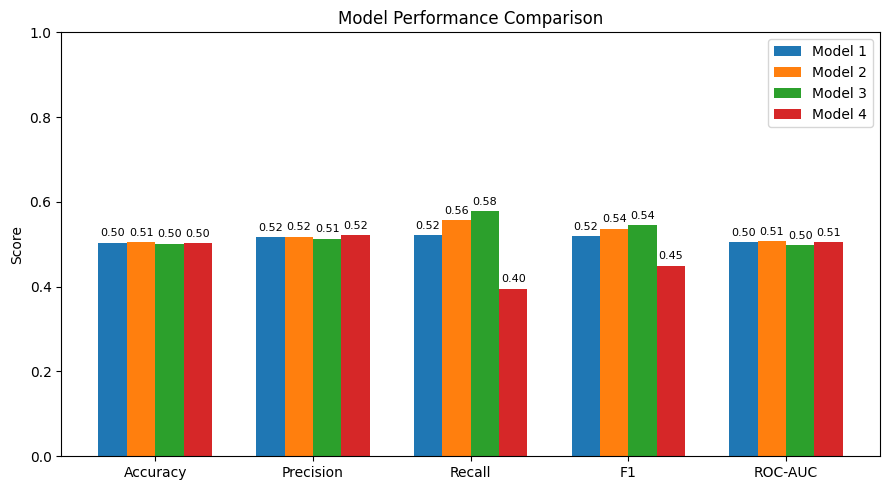

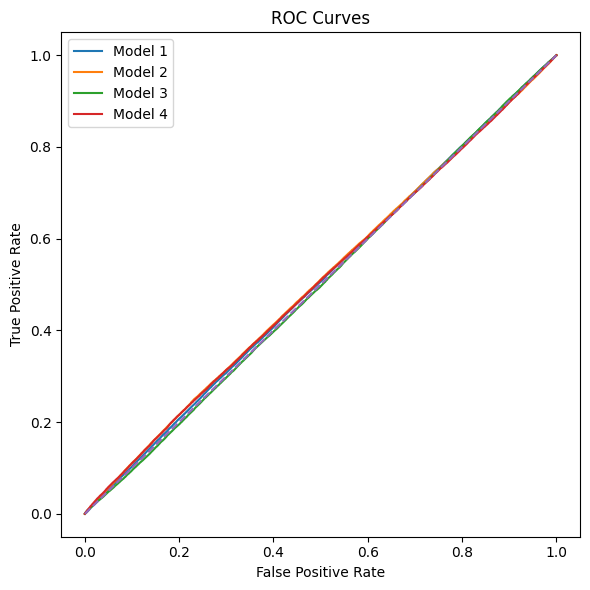

In [82]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)

# --- helpers ---
def is_binary(y): 
    vals = np.unique(y)
    return np.array_equal(vals, [0,1]) or np.array_equal(vals, [0]) or np.array_equal(vals, [1])

def eval_from_probs(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    out = {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
    }
    # ROC only if y_true is binary
    if is_binary(y_true):
        out["ROC-AUC"] = roc_auc_score(y_true, y_prob)
        fpr, tpr, _ = roc_curve(y_true, y_prob)
    else:
        out["ROC-AUC"] = np.nan
        fpr, tpr = None, None
    return out, fpr, tpr

results = []     # [(name, metrics_dict)]
roc_curves = []  # [(name, fpr, tpr)]

# --- collect probabilities for each model ---
# Model 1 (single input)
m1_prob = model1.predict(X_test).ravel()
m1_metrics, m1_fpr, m1_tpr = eval_from_probs(y_test, m1_prob)
results.append(("Model 1", m1_metrics))
roc_curves.append(("Model 1", m1_fpr, m1_tpr))

# Model 2-A / 2-B (replace model2 with the trained variant you want to compare)
m2_prob = model2.predict(X_test).ravel()
m2_metrics, m2_fpr, m2_tpr = eval_from_probs(y_test, m2_prob)
results.append(("Model 2", m2_metrics))
roc_curves.append(("Model 2", m2_fpr, m2_tpr))

# Model 3 (only include if its y_test is BINARY; otherwise skip or supply binary y_true for same samples)
m3_prob = model3.predict(X_test).ravel()
m3_metrics, m3_fpr, m3_tpr = eval_from_probs(y_test, m3_prob)  # ensure y_test ∈ {0,1}
results.append(("Model 3", m3_metrics))
roc_curves.append(("Model 3", m3_fpr, m3_tpr))

# Model 4-A / 4-B (dual input)
m4_prob = model4.predict([X_test, sym_test]).ravel()
m4_metrics, m4_fpr, m4_tpr = eval_from_probs(y_test, m4_prob)
results.append(("Model 4", m4_metrics))
roc_curves.append(("Model 4", m4_fpr, m4_tpr))

# --- comparison table ---
df = pd.DataFrame({name: met for name, met in results}).T  # rows=models, cols=metrics
print(df.round(3))

# --- grouped bar chart of metrics across models ---
metrics_to_plot = [c for c in df.columns if c != "ROC-AUC" or df["ROC-AUC"].notna().any()]
x = np.arange(len(metrics_to_plot))
width = 0.18

plt.figure(figsize=(9,5))
for i, (name, met) in enumerate(results):
    vals = [met.get(m, np.nan) for m in metrics_to_plot]
    plt.bar(x + i*width, vals, width, label=name)
    for xi, v in zip(x + i*width, vals):
        if np.isfinite(v):
            plt.text(xi, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=8)

plt.xticks(x + width*(len(results)-1)/2, metrics_to_plot)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

# --- ROC curves for all models (only those with binary y and ROC available) ---
plt.figure(figsize=(6,6))
plotted = False
for name, fpr, tpr in roc_curves:
    if fpr is not None:
        plt.plot(fpr, tpr, label=f"{name}")
        plotted = True
if plotted:
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No ROC curves plotted (no binary y_true available).")


## Interpretation: Model Comparison

Overall trend:
All models perform close to random (≈0.50 across metrics), indicating that price movement prediction from past OHLCV data alone remains a highly stochastic problem. None of the architectures achieve strong discriminative power (ROC-AUC ≈ 0.5).

Marginal improvements:
Model 3 shows a slight gain in recall (0.58) and F1-score (0.54), suggesting it captured marginally more upward movements, possibly due to its longer temporal context or regression-style target transformation.

Model 4 underperformance:
Despite its complexity and symbol embeddings, Model 4’s recall (0.40) and F1 (0.45) are weaker. This implies that the additional parameters did not generalize well, perhaps due to overfitting or noisy cross-stock correlations.

Takeaway:
Architectural depth and embeddings alone don’t overcome the weak predictive signal in short-horizon price data. Future improvement likely requires feature enrichment (technical indicators, sentiment, macro events) and longer context windows (≥ 60–100 days) rather than further model complexity.